#### Automatically Generating Tomogram Masks with SAM2

In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import matplotlib.pyplot as plt
import mrcfile, torch, copick, skimage 
import my_sam2_utils as utils
from PIL import Image
import numpy as np
from tqdm import tqdm

# use bfloat16 for the entire notebook.
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )    

using device: cuda


Load Copick Project

In [3]:
copick_config = '/hpc/projects/group.czii/krios1.processing/copick/24jul29c/run001/vatpase_config.json'
name = 'lysosome'

# Open Copick Project and Query All Available Runs
root = copick.from_file(copick_config)
run_ids = [run.name for run in root.runs]

Pull the Tomograms and labeled Points

In [4]:
runID = 'Position_13_Vol'

# Get Run
run = root.get_run(runID)

# Get Tomogram
vol = utils.get_tomogram(run)

# Get Lysosome Centers
points = utils.get_coordinates(run)

Getting denoised Tomogram with 10 A voxel size for the associated runID: Position_13_Vol


#### Option1 : Automatic Mask Generator (Pointless Annotation)

In [5]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.9,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=2000,
    use_m2m=True,
)

In [6]:
volNorm = vol.copy()
volNorm = (vol - vol.min()) / (vol.max() - vol.min())
volNorm = volNorm * 2 - 1

/hpc/projects/group.czii/jonathan.schwartz/sam2_dataportal/segment-anything-2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/hpc/projects/group.czii/jonathan.schwartz/sam2_dataportal/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


Total # of Available Masks:  14
Keys within a Mask:  dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


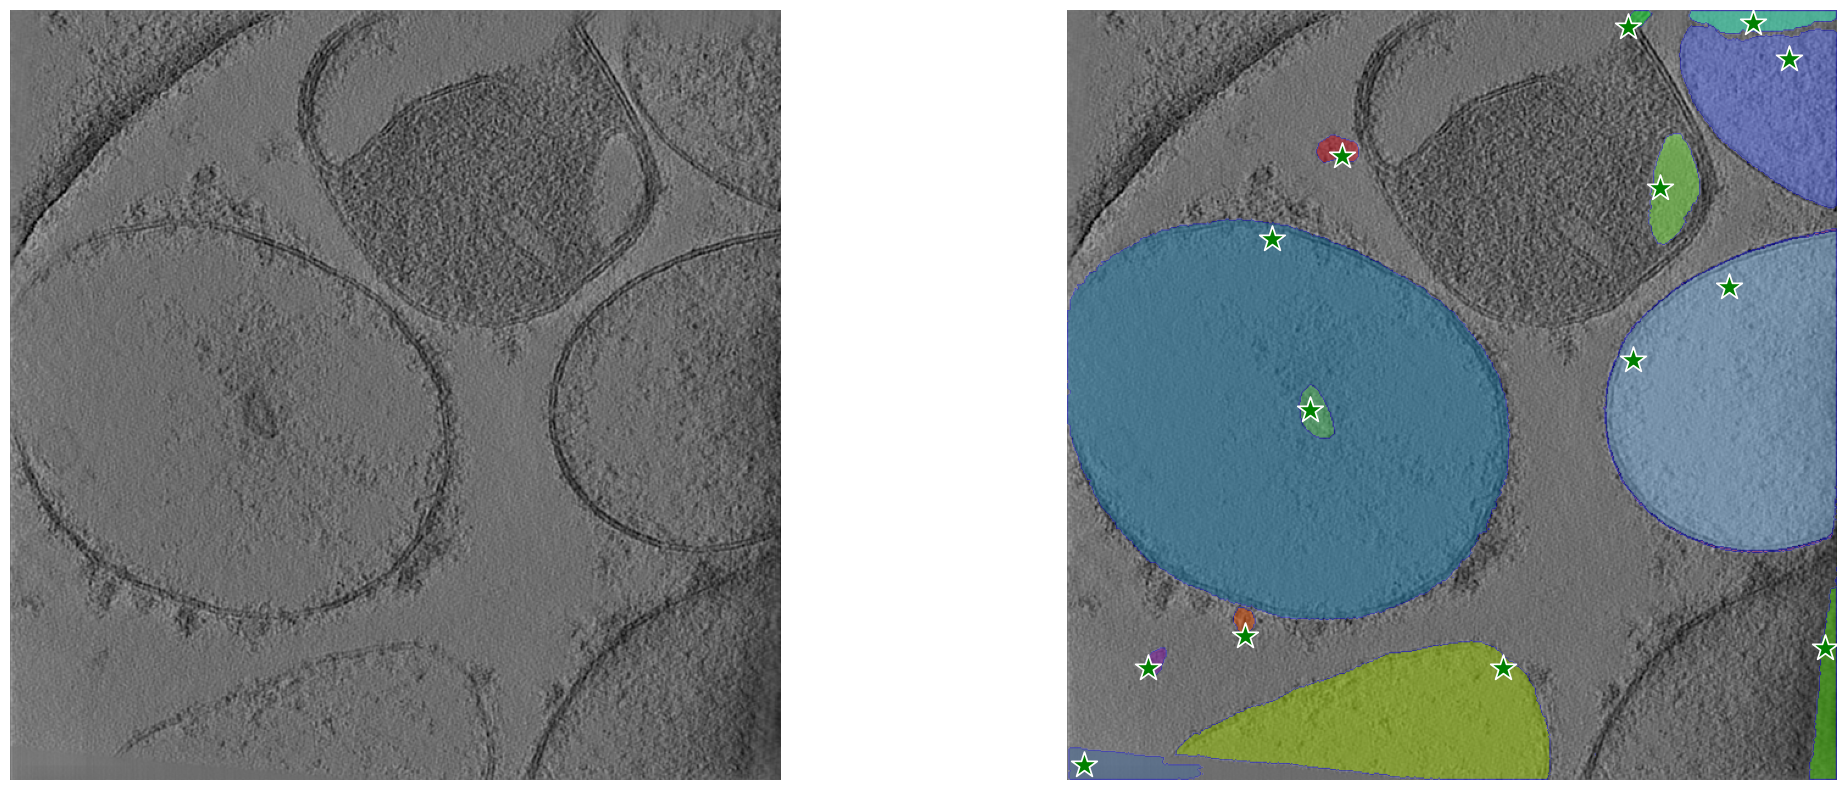

In [7]:
zSlice = int(points.mean(axis=0)[0])
deltaZ = int( (np.max(points[:,0]) - np.min(points[:,0]))) * 2
imScale = 1

# 
image = utils.project_tomogram(volNorm, zSlice, deltaZ) 

# Extend From Grayscale to RGB 
image = np.repeat(image[..., None], 3, axis=2)   

# Run Inference from Pre-trained Model
masks = mask_generator.generate(image)

print('Total # of Available Masks: ', len(masks))
print('Keys within a Mask: ', masks[0].keys())

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,10))
ax1.imshow(image, cmap='gray'); ax1.axis('off')
# Extract all 'point_coords'
auto_points = np.array([item['point_coords'] for item in masks])

# Reshape the array to (N, 2)
auto_points = auto_points.reshape(-1, 2)

labels = np.ones(auto_points.shape[0])
utils.show_points(auto_points, labels, plt.gca())
# ss = ax1.scatter(points[:,2], points[:,1], marker='*', c='g',  edgecolor='white', s=500)
# ax1.legend([],['Lysosome'],fontsize='15')

ax2.imshow(image, cmap='gray'); ax1.axis('off')
utils.show_anns(masks)
plt.axis('off')
plt.show() 

#### Option2: Video Segmentation

In [36]:
predictor.reset_state(inference_state)

In [8]:
from sam2.build_sam import build_sam2_tomogram_predictor

sam2_checkpoint = "../segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_tomogram_predictor(model_cfg, sam2_checkpoint, device=device) 

inference_state = predictor.init_state(vol)

100%|█████████████████████████████████████████| 186/186 [00:04<00:00, 40.95it/s]


/hpc/projects/group.czii/jonathan.schwartz/sam2_dataportal/segment-anything-2/sam2/sam2_tomogram_predictor.py:928: UserWarning: cannot import name '_C' from 'sam2' (/hpc/projects/group.czii/jonathan.schwartz/sam2_dataportal/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
/hpc/projects/group.czii/jonathan.schwartz/sam2_dataportal/scripts/my_sam2_utils.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame = torch.tensor(tomo[frame_id], device="cpu")


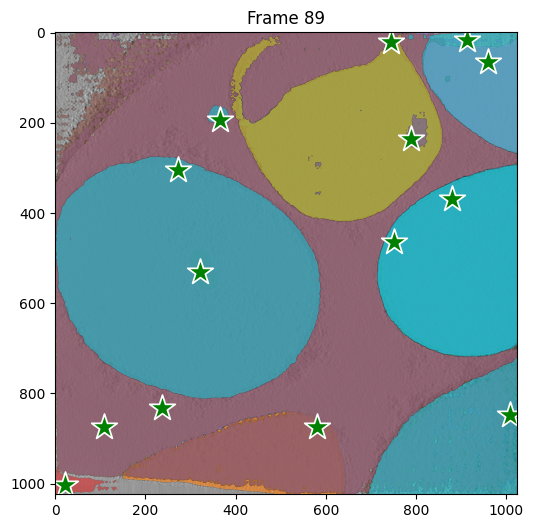

In [9]:
prompts = {}
ann_frame_idx = int(points.mean(axis=0)[0]) # int(points[0][0])  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
scale = predictor.image_size / vol.shape[1]
labels = np.array([1], np.int32)


for ii in range(auto_points.shape[0]):
    
    sam_points = ( auto_points[ii,:] * scale ).reshape(1, 2)
    ann_obj_id = ii + 1
    
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=sam_points,
        labels=labels,
    )
    prompts.setdefault(ann_obj_id, {})
    prompts[ann_obj_id].setdefault(ann_frame_idx, [])
    prompts[ann_obj_id][ann_frame_idx].append((sam_points, labels))
    
    # show the results on the current (interacted) frame
    if ii == 0:
        plt.figure(figsize=(9, 6))
        plt.title(f"frame {ann_frame_idx}")
        utils.show_tomo_frame(inference_state["images"], ann_frame_idx, plt.gca())

        # utils.show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])        
        
for i, out_obj_id in enumerate(out_obj_ids):
    utils.show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)
        
labels = np.ones(auto_points.shape[0])
utils.show_points(auto_points * scale, labels, plt.gca())

100%|███████████████████████████████████████████| 90/90 [00:03<00:00, 26.71it/s]


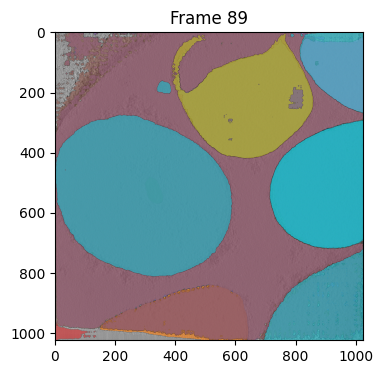

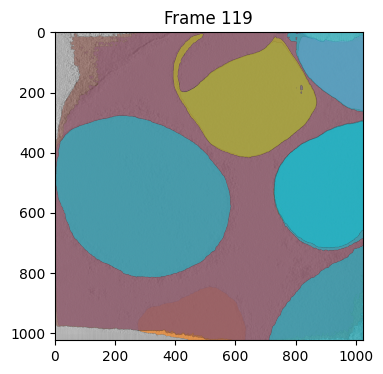

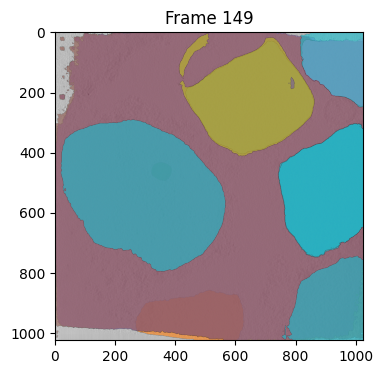

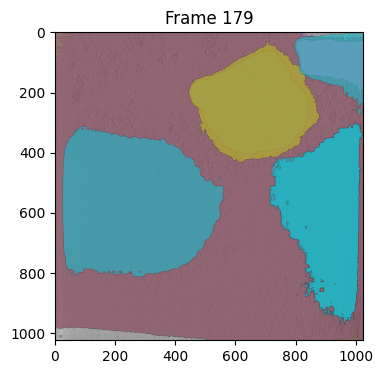

In [10]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=int(points.mean(axis=0)[0]), reverse=False):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in list(video_segments)[::vis_frame_stride]:
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    utils.show_tomo_frame(inference_state["images"], out_frame_idx, plt.gca())
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        utils.show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        
# TODO: Pull out Masks for Multiple Classes
nMasks = len(video_segments[int(points.mean(axis=0)[0])])
vol_mask = np.zeros( [vol.shape[0], vol.shape[1], vol.shape[2], nMasks], dtype=np.uint8)
for out_frame_idx in tqdm(list(video_segments)):
    for jj in range(nMasks):
        vol_mask[out_frame_idx,:,:,jj] = skimage.transform.resize(video_segments[out_frame_idx][jj+1][0,], (vol.shape[1], vol.shape[2]), anti_aliasing=False)

# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=int(points.mean(axis=0)[0]), reverse=True):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() for i, out_obj_id in enumerate(out_obj_ids)
    }

# # render the segmentation results every few frames
# vis_frame_stride = 30
# plt.close("all")
# for out_frame_idx in list(video_segments)[::vis_frame_stride]:
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     utils.show_tomo_frame(inference_state["images"], out_frame_idx, plt.gca())
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         utils.show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        
# Pull out Masks for Multiple Classes
for out_frame_idx in tqdm(list(video_segments)):
    for jj in range(nMasks):
        vol_mask[out_frame_idx,:,:,jj] = skimage.transform.resize(video_segments[out_frame_idx][jj+1][0,], (vol.shape[1], vol.shape[2]), anti_aliasing=False)

In [40]:
# Write the volume to an MRC file
with mrcfile.new('output.mrc', overwrite=True) as mrc:
    mrc.set_data(vol_mask)
    mrc.voxel_size = 1.0  # Set voxel size if required, e.g., in Angstroms
    mrc.update_header_from_data()  # Optionally update the header